## Ⅰ. Intro
###  1. 분석주제 
<br></br>
#### (1) 모두의 컴퍼니(모두의 주차장) 유저별 이용 횟수 예측하기
#### (2) 요일별 이용량에 대한 분석 - EDA
#### (3) 유저별 이용 count 값에 대한 분석 - EDA
<br></br>
### 2. 세부사항
#### 3주차 과제 제출에 포함되어야 하는 형태 (최소)
#### 모델링에 대한 결과 .ipynb 파일
#### Input : X데이터 : [user_id, +@]
#### Output : Count column 예측값
#### 2020.01.01~2020.09.30 : Training Data
#### 2020.10.01~2020.12.31 : Test Data
#### 2020.10.01~2020.12.31 구간에 대한 MSE, MAE 계산값

### 정보

•	유저 가입 정보: id, 가입일  
•	소비 행동 정보: 상품id, 점포 주소, 결제일, 결제건수  
•	외부 정보: 서울시 지점별 교통량 데이터 기온, 강수량, 풍속 등 기상데이터  

***

## Ⅱ . 머신러닝

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.style.use("fivethirtyeight")
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore')

In [2]:
np.random.seed(42) 

In [3]:
df= pd.read_csv('실전db.csv',encoding='cp949')
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR
...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     879271 non-null  int64 
 1   JOIN_DATE   879271 non-null  object
 2   D_TYPE      879271 non-null  object
 3   STORE_ID    879271 non-null  int64 
 4   GOODS_TYPE  879271 non-null  object
 5   DATE        879271 non-null  object
 6   COUNT       879271 non-null  int64 
 7   AD1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


- 종속변수 분리

In [5]:
df.columns=[i.lower() for i in df.columns.values]

#### 전처리

In [6]:
df['join_date']=pd.to_datetime(df['join_date'])
df['date']=pd.to_datetime(df['date'])

In [7]:
df['weekday']=[i.lower() for i in df.date.dt.day_name()]

In [8]:
df['j_y']=df['join_date'].dt.year
df['j_m']=df['join_date'].dt.month
df['j_day']=df['join_date'].dt.day
df['j_wday']=df['join_date'].dt.weekday
df['p_y']=df['date'].dt.year
df['p_m']=df['date'].dt.month
df['p_day']=df['date'].dt.day
df['p_wday']=df['date'].dt.weekday

In [9]:
Train_X=df.loc[df['date']<'20201001',:].drop('count',axis=1)
Train_y=df.loc[df['date']<'20201001','count']
Train_X=Train_X.drop(['join_date','date'],axis=1)
Test_X=df.loc[df['date']>='20201001',:].drop('count',axis=1)
Test_X=Test_X.drop(['join_date','date'],axis=1)
Test_y=df.loc[df['date']>='20201001','count']

In [10]:
Train_X.columns

Index(['user_id', 'd_type', 'store_id', 'goods_type', 'ad1', 'weekday', 'j_y',
       'j_m', 'j_day', 'j_wday', 'p_y', 'p_m', 'p_day', 'p_wday'],
      dtype='object')

In [11]:
Test_X

,user_id,d_type,store_id,goods_type,ad1,weekday,j_y,j_m,j_day,j_wday,p_y,p_m,p_day,p_wday
623579,15521,AA,182320,A,JRR,thursday,2014,9,12,4,2020,10,1,3
623580,17651,BB,82434,D,J,thursday,2014,9,19,4,2020,10,1,3
623581,26388,BB,182320,A,JRR,thursday,2014,10,25,5,2020,10,1,3
623582,81772,BB,204438,A,DJ,thursday,2015,5,2,5,2020,10,1,3
623583,92258,AA,220745,A,SD,thursday,2015,5,24,6,2020,10,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,BB,219886,B,GN,thursday,2020,12,31,3,2020,12,31,3
879267,1830570,BB,82433,B,CY,thursday,2020,12,31,3,2020,12,31,3
879268,1830580,AA,92020,B,JRR,thursday,2020,12,31,3,2020,12,31,3
879269,1830589,BB,92437,B,J,thursday,2020,12,31,3,2020,12,31,3


In [12]:
Train_y

0         1
1         1
2         1
3         1
4         1
         ..
623574    1
623575    1
623576    1
623577    2
623578    1
Name: count, Length: 623579, dtype: int64

In [13]:
Test_y

623579    1
623580    1
623581    1
623582    1
623583    1
         ..
879266    1
879267    1
879268    1
879269    1
879270    1
Name: count, Length: 255692, dtype: int64

In [14]:
col1=Train_X.columns.values

train_numcol=[]
train_strcol=[]
for i in col1:
    if Train_X[i].dtype == 'int64':
        train_numcol.append(i)
    elif Train_X[i].dtype == 'object':
        train_strcol.append(i)
        

In [15]:
col2=Test_X.columns.values
test_numcol=[]
test_strcol=[]
for i in col1:
    if Train_X[i].dtype == 'int64':
        test_numcol.append(i)
    elif Train_X[i].dtype == 'object':
        test_strcol.append(i)

In [16]:
# 스케일링
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
Train_X.loc[:,train_numcol]=scaler.fit_transform(Train_X.loc[:,train_numcol])
Test_X.loc[:,test_numcol]=scaler.fit_transform(Test_X.loc[:,test_numcol])

In [17]:
# 인코딩
Train_X=pd.get_dummies(Train_X)
Test_X=pd.get_dummies(Test_X)

In [18]:
a1=Train_X.columns.values

In [19]:
b1=Test_X.columns.values

In [20]:
# test에 없는 train 컬럼
l12=[]
for i in a1:
    if i not in b1:
        l12.append(i)
l12

['ad1_NW', 'ad1_SP', 'ad1_WOID']

In [21]:
# train에 없는 test 컬럼
l11=[]
for i in b1:
    if i not in a1:
        l11.append(i)
l11

['ad1_ADS', 'ad1_CVB', 'ad1_DY', 'ad1_GR', 'ad1_VO', 'ad1_WH', 'ad1_X']

In [22]:
Train_X=Train_X.drop(l12,axis=1)

In [23]:
Test_X=Test_X.drop(l11,axis=1)

#### 모델링

In [24]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb_reg=XGBRegressor(random_state=42)

#params = [{ 'max_depth' : [3,7,10]}]

#girdcv=GridSearchCV(estimator=xgb_reg,
#                       param_grid=params,
#                       scoring='neg_mean_squared_error',
#                       cv=5)

xgb_reg.fit(Train_X,Train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
# grid_df = pd.DataFrame(girdcv.cv_results_)
# grid_df.loc[:, ['mean_test_score', "params"]]

In [26]:
y_pred=xgb_reg.predict(Test_X)

In [27]:
y_pred

array([1.0164901 , 0.9944212 , 1.0125068 , ..., 0.98289543, 0.97814393,
       0.9943313 ], dtype=float32)

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [29]:
Test_y

623579    1
623580    1
623581    1
623582    1
623583    1
         ..
879266    1
879267    1
879268    1
879269    1
879270    1
Name: count, Length: 255692, dtype: int64

In [30]:
Test_y

623579    1
623580    1
623581    1
623582    1
623583    1
         ..
879266    1
879267    1
879268    1
879269    1
879270    1
Name: count, Length: 255692, dtype: int64

#### MSE

In [31]:
mean_squared_error(Test_y,y_pred)

0.4574057987965948

#### MAE

In [32]:
mean_absolute_error(Test_y,y_pred)

0.054749509685301574

***

## Ⅲ. 요일별 이용량에 대한 분석 - EDA
- 금>목>수>토>화>월>일순으로 데이터가 있고, 일요일이 다른 요일에 비해 상당히 적다.
- 어플에서는 평일 ,휴일, 당일, 심야 3,5,12,24시간권 등이 있다.
- 주어진 db데이터 내에서는 시간에 대해서는 알 수 없고, 평일 휴일을 구분할 수 있다.

In [33]:
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,weekday,j_y,j_m,j_day,j_wday,p_y,p_m,p_day,p_wday
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,wednesday,2014,1,7,1,2020,1,1,2
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,wednesday,2014,2,14,4,2020,1,1,2
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,wednesday,2014,11,20,3,2020,1,1,2
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,wednesday,2014,12,4,3,2020,1,1,2
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,wednesday,2014,12,7,6,2020,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,thursday,2020,12,31,3,2020,12,31,3
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,thursday,2020,12,31,3,2020,12,31,3
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,thursday,2020,12,31,3,2020,12,31,3
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,thursday,2020,12,31,3,2020,12,31,3


In [34]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
class Calendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year', month=1, day=1),
        Holiday('KR_New Year1', month=1, day=24),
        Holiday('KR_New Year2', month=1, day=25),
        Holiday('KR_New Year3', month=1, day=26),
        Holiday('3.1', month=3, day=1),
        Holiday('Buddha Day', month=4, day=30),
        Holiday('Memorial Day', month=6, day=6),
        Holiday('Liberation Day', month=8, day=15),
        Holiday('KR_Thanksgiving1', month=9, day=30),
        Holiday('KR_Thanksgiving2', month=10, day=1),
        Holiday('KR_Thanksgiving3', month=10, day=2),
        Holiday('National Foundation Day', month=10, day=3),
        Holiday('Hangul Day', month=10, day=9),
        Holiday('Christmas', month=12, day=25)
    ]
       
dr = pd.date_range(start='2020-01-01', end='2020-12-31')
cal = Calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
df['holiday'] = df['date'].isin(holidays)

In [35]:
# 요일별 이용횟수의 합
df.groupby(df.date.dt.day_name())['count'].sum().sort_values(ascending=False)

date
Friday       141837
Thursday     137323
Wednesday    136034
Saturday     135906
Tuesday      134288
Monday       130447
Sunday        89004
Name: count, dtype: int64

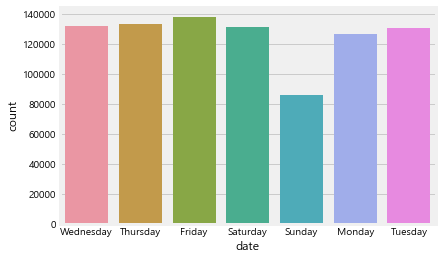

In [36]:
sns.countplot(x= df.date.dt.day_name(), data=df)

- 해당 주차장 예약 이용 서비스는 일요일에 특히 적고 금요일에 많이 이용하는 특징이 있다.

In [37]:
df['weekday']=[i.lower() for i in df.date.dt.day_name()]

In [38]:
wday=['monday','tuesday','wednesday','thursday','friday','saturday','sunday']
pd.crosstab(df['weekday'], 
            df['goods_type'], normalize=1).loc[wday,:].style.background_gradient(cmap ='Blues')

goods_type,A,B,C,D
weekday,,,,
monday,0.146114,0.143351,0.127574,0.213733
tuesday,0.146608,0.174994,0.133338,0.154118
wednesday,0.146542,0.182097,0.138995,0.157152
thursday,0.146355,0.192279,0.139452,0.166153
friday,0.142118,0.234915,0.151819,0.176720
saturday,0.162430,0.052454,0.186127,0.091065
sunday,0.109833,0.019909,0.122695,0.041058


- 요일별로 goods_type의 차이가 있음

#### (2) 요일별 지역별(store_id)별 분석
- 이상값 제거

In [39]:
a1=df.groupby(['weekday','store_id'])['count'].sum().unstack()

In [40]:
q1=df.groupby(['weekday','store_id'])['count'].sum().quantile(0.25)

In [41]:
q3=df.groupby(['weekday','store_id'])['count'].sum().quantile(0.75)

In [42]:
iqr=q3-q1

In [43]:
a11=df.groupby(['weekday','store_id'])['count'].sum().reset_index()
a1=a11.query("(count >= @q1-1.5*@iqr) and (count <= @q3+1.5*@iqr)")
a1=a1.fillna(0.0)

In [44]:
a1=a1.pivot(index='weekday',columns='store_id',values='count')

#### 전체 데이터에서 요일별 이용횟수의 평균을 구하면 차이는 소수점단위로 있으나 이용횟수는 정수단위이므로 의미가 없다.
#### 반면 <U>요일별 주차장별 이용횟수의 합계의 요일별 평균은 차이가 있다.</U>

In [45]:
# 요일별 이용횟수의 평균
df.groupby('weekday')['count'].mean().reset_index().style.background_gradient(cmap ='Greys')

,weekday,count
0,friday,1.028423
1,monday,1.026721
2,saturday,1.033663
3,sunday,1.032050
4,thursday,1.027744
5,tuesday,1.027602
6,wednesday,1.028340


In [46]:
std_a1=scaler.fit_transform(a1)

In [47]:
std_a1=pd.DataFrame(std_a1,columns=a1.columns,index=a1.index)

In [48]:
# 이상값 제거후 표준화한 요일별 주차장별 이용횟수의 합계의 요일별 평균
a1mean=a1.mean(1)
a1mean.reset_index().style.background_gradient(cmap ='Greys')

,weekday,0
0,friday,53.679894
1,monday,49.424516
2,saturday,60.358696
3,sunday,56.235849
4,thursday,49.200000
5,tuesday,48.520805
6,wednesday,48.686842


- 토요일과 일요일 금요일에 순서대로 요일별 주차장별 이용횟수의 합계의 평균이 높다.
- 표준화한 경우에는 같은 기준 토요일과 일요일의 평균이 높다.

In [49]:
# 표준화한 요일별 주차장별 이용횟수의 합계의 요일별 평균
std_a1mean=std_a1.mean(1)
std_a1mean=pd.Series([abs(i) for i in std_a1mean],index=std_a1mean.index)
std_a1mean.reset_index().style.background_gradient(cmap ='Greys')

,weekday,0
0,friday,0.157142
1,monday,0.011293
2,saturday,0.474830
3,sunday,0.400201
4,thursday,0.000455
5,tuesday,0.138025
6,wednesday,0.075742


- 일요일은 이용횟수가 비교적 낮은쪽에 모여있고, 토요일은 제일 낮은 횟수는 제외하고 비교적 쌍봉의 형태에 가깝다.
- 즉, 

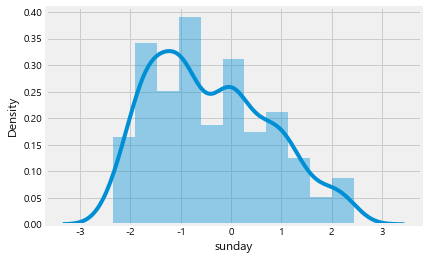

In [50]:
sns.distplot(std_a1.loc['sunday',:])

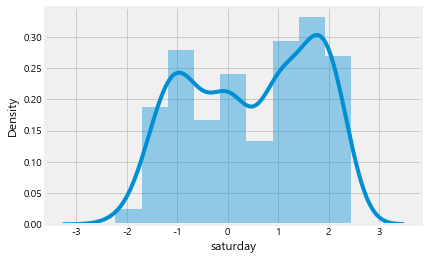

In [51]:
sns.distplot(std_a1.loc['saturday',:])

Text(0.5, 1.0, '요일별 주차장별 이용횟수의 요일별 평균 그래프')

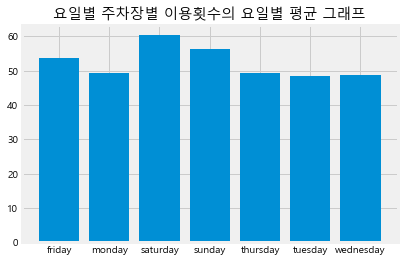

In [52]:
plt.bar(x=a1mean.index,height=a1mean)
plt.title("요일별 주차장별 이용횟수의 요일별 평균 그래프")

Text(0.5, 1.0, '표준화한 요일별 주차장별 이용횟수의 요일별 평균 그래프')

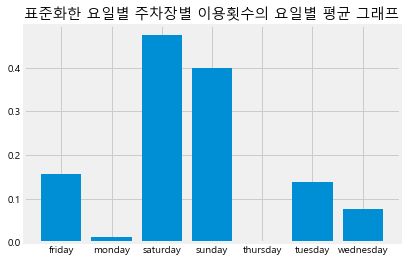

In [53]:
plt.bar(x=std_a1mean.index,height=std_a1mean)
plt.title("표준화한 요일별 주차장별 이용횟수의 요일별 평균 그래프")

- 주차장별 요일별 이용횟수의 요일별 평균의 경우, 일요일이 2위인 것은 요일별 데이터수의 총합에서의 일요일이 순위가 제일 낮은 것과는  다르다.
- 그리고, 토요일의 경우 데이터의 수에서는 금, 목, 수요일에 밀려 4위 였으나, 주차장별 요일별 평균의 경우 가장 많은 이용횟수를 가진 요일이다.
- 표준화 할경우 일요일과 토요일 그룹의 평균과 다른 요일의 평균의 편차는 더 커진다.
- 가장 눈에 띄는 것은 데이터의 수가 일요일 보다 많지만 주자창별 이용회수의 평균이 다른 요일들에 비해 높다는 점이다.  
    그러므로, <U>일요일이 다른 요일과 어떠한 차이가 있는지 비교해 볼 필요가 있다.</U>

#### 1) Goodstype의 경우에는 B와 C가 차지하는 구성 비율의 순서가 차이가 있다.
    - 대체로 다른 요일은 B와 C가 차이가 크지 않고 B가 더 높은데, 일요일은 C가 B보다 약 7배 차이나며 더 높다.

In [54]:
df.query("weekday == 'sunday'").goods_type.value_counts(normalize=True)

A    0.776612
C    0.186607
B    0.027365
D    0.009416
Name: goods_type, dtype: float64

In [55]:
df.query("weekday == 'monday'").goods_type.value_counts(normalize=True)

A    0.701280
B    0.133748
C    0.131702
D    0.033270
Name: goods_type, dtype: float64

In [56]:
df.query("weekday == 'tuesday'").goods_type.value_counts(normalize=True)

A    0.684109
B    0.158738
C    0.133830
D    0.023324
Name: goods_type, dtype: float64

In [57]:
df.query("weekday == 'wednesday'").goods_type.value_counts(normalize=True)

A    0.675511
B    0.163178
C    0.137816
D    0.023495
Name: goods_type, dtype: float64

In [58]:
df.query("weekday == 'thursday'").goods_type.value_counts(normalize=True)

A    0.667929
B    0.170586
C    0.136892
D    0.024593
Name: goods_type, dtype: float64

In [59]:
df.query("weekday == 'friday'").goods_type.value_counts(normalize=True)

A    0.628363
B    0.201911
C    0.144384
D    0.025341
Name: goods_type, dtype: float64

#### 2) D_TYPE의 경우에는 일요일과 다른요일의 차이가 거의 없다.

In [60]:
df.query("weekday == 'sunday'").d_type.value_counts(normalize=True)

AA    0.549687
BB    0.448609
CC    0.001705
Name: d_type, dtype: float64

In [61]:
df.query("weekday == 'monday'").d_type.value_counts(normalize=True)

AA    0.562589
BB    0.435696
CC    0.001716
Name: d_type, dtype: float64

In [62]:
df.query("weekday == 'tuesday'").d_type.value_counts(normalize=True)

AA    0.561444
BB    0.436758
CC    0.001798
Name: d_type, dtype: float64

In [63]:
df.query("weekday == 'wednesday'").d_type.value_counts(normalize=True)

AA    0.559686
BB    0.438462
CC    0.001852
Name: d_type, dtype: float64

In [64]:
df.query("weekday == 'thursday'").d_type.value_counts(normalize=True)

AA    0.561310
BB    0.436849
CC    0.001841
Name: d_type, dtype: float64

In [65]:
df.query("weekday == 'friday'").d_type.value_counts(normalize=True)

AA    0.559235
BB    0.438865
CC    0.001900
Name: d_type, dtype: float64

#### 3) AD1의 경우에는 일요일에 J라는 지역의 주차비율이 다른 일자에 23%대와 비교하면 12%로 10%가까이 차이가 난다.  
    (AD1의 경우에는 팀회의 결과, 지역명이라는 결론을 냈고 GN이 강남 MP가 마포 이런식이었음)

In [66]:
df.query("weekday == 'sunday'").ad1.value_counts(normalize=True)[:5]

GN     0.206505
JRR    0.172379
J      0.125823
SC     0.110993
MP     0.100093
Name: ad1, dtype: float64

In [67]:
df.query("weekday == 'monday'").ad1.value_counts(normalize=True)[:5]

J      0.230221
GN     0.190749
JRR    0.135567
SC     0.076709
MP     0.066658
Name: ad1, dtype: float64

In [68]:
df.query("weekday == 'tuesday'").ad1.value_counts(normalize=True)[:5]

J      0.229460
GN     0.188030
JRR    0.138712
SC     0.078053
MP     0.068579
Name: ad1, dtype: float64

In [69]:
df.query("weekday == 'wednesday'").ad1.value_counts(normalize=True)[:5]

J      0.228114
GN     0.188857
JRR    0.138769
SC     0.079707
MP     0.068617
Name: ad1, dtype: float64

In [70]:
df.query("weekday == 'thursday'").ad1.value_counts(normalize=True)[:5]

J      0.224225
GN     0.188286
JRR    0.138913
SC     0.082924
MP     0.070860
Name: ad1, dtype: float64

In [71]:
df.query("weekday == 'friday'").ad1.value_counts(normalize=True)[:5]

J      0.213433
GN     0.193247
JRR    0.138032
SC     0.082600
MP     0.076060
Name: ad1, dtype: float64

#### 5) Store_id의 경우에는 일요일에 182335의 경우 요일별 이용비중이 2등인 주차장인데 토요일은 5등이고, 나머지 요일은 5등내에 없다.

In [72]:
df.query("weekday == 'sunday'").store_id.value_counts(normalize=True)[:5]

220655    0.029557
182335    0.020165
105033    0.019910
182320    0.019527
90542     0.016605
Name: store_id, dtype: float64

In [73]:
df.query("weekday == 'monday'").store_id.value_counts(normalize=True)[:5]

220557    0.025116
220893    0.022510
92437     0.020448
91853     0.019449
109037    0.019441
Name: store_id, dtype: float64

In [74]:
df.query("weekday == 'tuesday'").store_id.value_counts(normalize=True)[:5]

220557    0.023531
220893    0.021816
1109      0.020011
91853     0.019437
92437     0.019069
Name: store_id, dtype: float64

In [75]:
df.query("weekday == 'wednesday'").store_id.value_counts(normalize=True)[:5]

220557    0.022618
220893    0.021045
1109      0.020350
92437     0.019995
91853     0.019239
Name: store_id, dtype: float64

In [76]:
df.query("weekday == 'thursday'").store_id.value_counts(normalize=True)[:5]

220557    0.023006
220893    0.021113
1109      0.020140
92437     0.019549
91853     0.018815
Name: store_id, dtype: float64

In [77]:
df.query("weekday == 'friday'").store_id.value_counts(normalize=True)[:5]

220893    0.021926
220557    0.020911
220848    0.019330
92437     0.018489
1109      0.017946
Name: store_id, dtype: float64

In [78]:
df.query("weekday == 'saturday'").store_id.value_counts(normalize=True)[:5]

220655    0.028347
220848    0.026848
105033    0.019433
220893    0.017273
182335    0.016740
Name: store_id, dtype: float64

### Summary
#### 위의 분석으로 다음과 같은 인사이트를 얻을 수 있다.
#### 일요일이 전체에서 데이터수는 적지만 주차장별 이용횟수의 평균이 월요일부터 금요일보다 높다.
#### 이와 같은 사실에 근거해 다른 요일과의 차이를 비교하면 다음의 차이가 있다
1. Goods_type에서 일요일은 다른 요일에 비해 C의 비중이 높고, B의 비중이 적다.
2. AD1을 지역으로 볼 경우, 일요일은 다른 요일에 비해 J지역의 사용률이 10%가까이 낮아진다.
3. 사용주차장의 고유ID의 순위의 경우, 182335라는 주차장은 월-금에는 5위내에 없고, 토요일은 5등인데 일요일에는 두번째로 많이 이용하는 주차장이다.
#### 이처럼 월-목요일과 금,토,일의 경향이 나뉘는 것을 고려하여 weekdayYN변수를 생성한다.

In [79]:
l1=[]
for i in range(df.shape[0]):
    if (df['weekday'][i] not in ['friday','saturday','sunday']) :
        l1.append('weekday')
    else:
        l1.append(df['weekday'][i])
        
df['weekdayYN']=l1

***

## Ⅳ. 유저별 이용 count에 대한 분석

#### 유저들의 가입년도별 주차장별 결제건수의 합의 평균

In [80]:
df.groupby(['j_y','store_id'])['count'].sum().unstack()

store_id,4,8,161,179,262,295,353,453,456,466,...,231420,231427,231428,231429,231430,231431,231434,231444,231453,231465
j_y,,,,,,,,,,,,,,,,,,,,,
1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2015,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,3.0,1.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,3.0,NaN,1.0,NaN
2017,3.0,5.0,NaN,7.0,8.0,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,8.0,2.0,NaN,11.0,NaN,1.0,5.0
2018,5.0,11.0,1.0,10.0,17.0,NaN,NaN,1.0,NaN,9.0,...,NaN,NaN,NaN,9.0,1.0,1.0,5.0,NaN,5.0,NaN
2019,4.0,15.0,NaN,22.0,23.0,2.0,NaN,NaN,1.0,12.0,...,NaN,NaN,2.0,17.0,1.0,NaN,8.0,2.0,8.0,2.0
2020,10.0,13.0,4.0,21.0,23.0,1.0,1.0,1.0,5.0,47.0,...,4.0,1.0,2.0,36.0,11.0,7.0,24.0,1.0,8.0,6.0


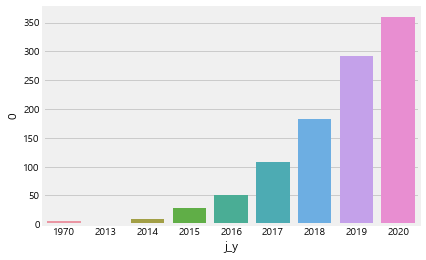

In [81]:
sns.barplot(x='j_y',y=0, data=df.groupby(['j_y','store_id'])['count'].sum().unstack().mean(1).reset_index())

-  연도별로 보면 유저들이 비교적 최근에 가입할수록 주차장별 결제횟수의 합계의 평균이 높음

#### 유저들의 가입월별 주차장별 결제건수의 합의 평균

In [82]:
df.groupby(['j_m','store_id'])['count'].sum().unstack()

store_id,4,8,161,179,262,295,353,453,456,466,...,231420,231427,231428,231429,231430,231431,231434,231444,231453,231465
j_m,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.0,1.0,4.0,4.0,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,2.0,NaN,3.0,NaN
2,1.0,3.0,NaN,3.0,6.0,NaN,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,4.0,1.0,NaN,4.0,NaN,1.0,NaN
3,6.0,NaN,1.0,3.0,6.0,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,3.0,NaN,NaN,3.0,1.0,4.0,2.0
4,NaN,5.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,4.0,NaN,2.0,1.0,NaN,1.0,1.0
5,1.0,1.0,NaN,4.0,7.0,1.0,NaN,NaN,NaN,4.0,...,NaN,NaN,1.0,1.0,NaN,NaN,4.0,NaN,NaN,NaN
6,2.0,10.0,NaN,2.0,6.0,NaN,NaN,NaN,NaN,25.0,...,NaN,NaN,1.0,6.0,NaN,NaN,3.0,NaN,2.0,1.0
7,2.0,7.0,NaN,4.0,12.0,NaN,1.0,NaN,3.0,7.0,...,NaN,NaN,NaN,9.0,NaN,NaN,4.0,NaN,1.0,1.0
8,2.0,6.0,2.0,13.0,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,5.0,5.0,NaN,8.0,NaN,3.0,1.0
9,2.0,4.0,1.0,6.0,5.0,2.0,NaN,NaN,NaN,4.0,...,1.0,NaN,NaN,11.0,1.0,NaN,4.0,NaN,NaN,1.0


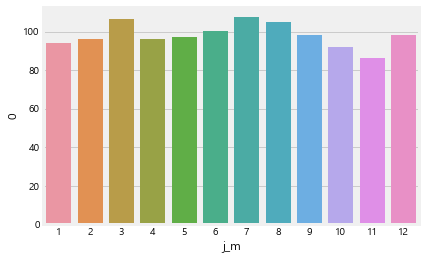

In [83]:
sns.barplot(x='j_m',y=0,data=df.groupby(['j_m','store_id'])['count'].sum().unstack().mean(1).reset_index().sort_values(by=0,ascending=False))

In [84]:
df.groupby(['j_m','store_id'])['count'].sum().unstack().mean(1).reset_index().style.background_gradient(cmap ='Greys')

,j_m,0
0,1,93.849797
1,2,95.886457
2,3,106.729986
3,4,96.111260
4,5,96.958333
5,6,100.334204
6,7,107.418043
7,8,104.682519
8,9,98.348045
9,10,91.711418


- 가입 월별로보면, 7월,3월,8월에 가입한 고객이 주차장별 결제건수의 합이 높고 11월에 가입한 고객이 결제건수의 합의 평균이 제일 낮음  

In [85]:
# 이력 CLV(고객생애가치) 구하기
tempt=df.groupby('user_id')['count'].sum().reset_index().sort_values(by='count',ascending=False)
tempt

,user_id,count
44115,999665,7919
100781,1514190,284
16448,591610,245
90227,1467323,239
76230,1355841,235
...,...,...
45671,1023974,1
110166,1551355,1
45674,1024027,1
45676,1024047,1


- 165425명의 고객을 모두 다룰수는 없으니 상위 100명 출력  
    user_id가 44115인 고객은 이용횟수가 터무니없이 많아 이상값으로 판단이 되어서 제거해야함을 확인

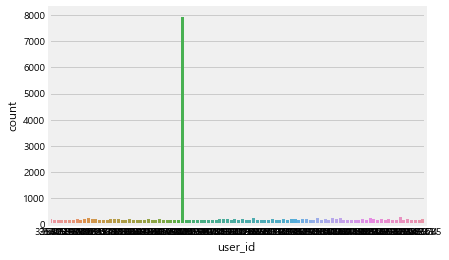

In [86]:
sns.barplot(x='user_id',y='count',data=tempt.iloc[:100,:])

In [87]:
# 제거
df=df.loc[df.user_id!=44115,:]

#### 유저별 사용 지역별 분석

In [88]:
tempt2=df.groupby(['user_id','ad1'])['count'].sum().sort_values(ascending=False)

In [89]:
tempt2.reset_index()

,user_id,ad1,count
0,999665,J,1917
1,999665,GN,1310
2,999665,JRR,1009
3,999665,SC,904
4,999665,MP,384
...,...,...,...
255193,1179447,J,1
255194,1179464,CD,1
255195,1179474,GN,1
255196,1179476,J,1


In [90]:
reg=tempt2.reset_index().groupby('user_id')['count'].mean().sort_values(ascending=False)
reg=reg.reset_index()

In [91]:
f1= lambda x: x/x.sum()*100
reg['pct']=reg[['count']].apply(f1,0)

In [92]:
reg

,user_id,count,pct
0,999665,282.821429,0.046741
1,591610,245.000000,0.040490
2,1467323,239.000000,0.039498
3,1355841,235.000000,0.038837
4,1365069,222.000000,0.036689
...,...,...,...
165420,1322915,1.000000,0.000165
165421,1322888,1.000000,0.000165
165422,1322884,1.000000,0.000165
165423,1322880,1.000000,0.000165


In [93]:
reg['pct_cumsum']=reg.pct.cumsum()

In [94]:
l1=[]
for i in reg.pct_cumsum:
    if i > 66:
        l1.append('하')
    elif i > 33:
        l1.append('중')
    else:
        l1.append('상')


reg['reg_grade']=l1

In [95]:
a=tempt2.reset_index()
a.columns=['user_id','ad1','결제합계']
a=a.groupby('ad1')['결제합계'].mean()
a.sort_values(ascending=False)

ad1
DY      48.000000
BUD      8.217391
DIV      7.090909
GS       4.824812
P        4.695421
          ...    
VO       1.000000
WOID     1.000000
NW       1.000000
SP       1.000000
GR       1.000000
Name: 결제합계, Length: 85, dtype: float64

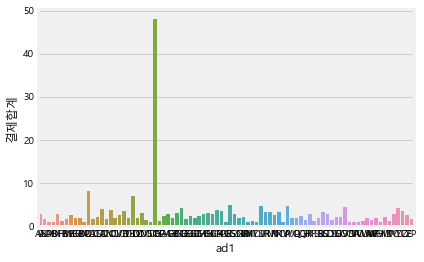

In [96]:
sns.barplot(x='ad1',y='결제합계',data=a.reset_index())

- 위 데이터에 따르면 다음의 결과를 도출할 수 있다.
- user_id가 999665인 사람이 제일 많이 결제하며, 다른 상위권 사용자와 비교해도 10,000건 정도의 차이가 있다.
- 유저별 지역별 결제건수의 합계의 지역별 평균의 경우에는 DY가 제일 많이 결제되는 지역으로, 사용자에서 이상값을 찾은것처럼
    이상값으로 판단되어 제거할 필요가 있다.

In [97]:
df=df.query("ad1 !='DY'")

In [98]:
df=pd.merge(df,reg.loc[:,['user_id','reg_grade']],on='user_id',how='left')

In [99]:
df.shape[0]

879270

***

#### 교통량 데이터로 혼잡도 변수 추가

In [100]:
traffic=pd.read_csv('2020trafficsum.csv',encoding='utf-8')

In [101]:
traffic=traffic.set_index('DATE')

In [102]:
df_traf=traffic.iloc[:,4:].sum(1)
df_traf.quantile(0.75)

42715.0

In [103]:
l1=[]
for i in range(df_traf.shape[0]):
    if df_traf[i] > 42715:
        l1.append(0)
    else :
        l1.append(1)

In [104]:
df_traf=df_traf.reset_index()
df_traf['confusion']=l1

In [105]:
df_traf=df_traf.loc[:,['DATE','confusion']]
df_traf.columns=['date','confusion']

In [106]:
df_traf=df_traf.groupby(['date'])['confusion'].sum()

In [107]:
df_traf=df_traf.reset_index()

In [108]:
df_traf.date=pd.to_datetime(df_traf.date)

In [109]:
df=pd.merge(df,df_traf,on='date',how='left')

In [110]:
df.shape[0]

879270

#### 기상데이터 추가

In [111]:
weather=pd.read_csv('서울시_기상데이터.csv',encoding='cp949')

In [112]:
weather.head()

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01 1:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2
1,108,2020-01-01 2:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1
2,108,2020-01-01 3:00,-5.6,0.0,0.0,46,NaN,NaN,-2.7,3.1
3,108,2020-01-01 4:00,-5.4,NaN,0.0,50,NaN,NaN,-2.5,3.0
4,108,2020-01-01 5:00,-5.2,NaN,0.0,55,NaN,NaN,-2.2,3.0


In [113]:
weather['일시']=pd.to_datetime(weather.일시).dt.strftime("%Y-%m-%d")

In [114]:
weather['일시']=pd.to_datetime(weather.일시)

In [115]:
weather=weather.fillna(0)

In [116]:
weather=weather.groupby('일시')[['적설량','풍속','강수량']].mean()

1. 일일 강수량이 80이상(폭우 기준)  
2. 일일 적설량이 5이상(데이터가 실제 대설주의보를 측정하는 신적설은 아닌것 같지만 적절한 기준이라 판단해 사용)  
3. 풍속이 4이상(임의로 설정한 기준)  
    1~3조건 중 하나라도 만족하는 날은 Bad_Weather로 선정

In [117]:
l1=[]
for i in range(weather.shape[0]):
    if weather['적설량'][i] > 5 or weather['풍속'][i] > 4 or weather['강수량'][i] > 80:
        l1.append('B_W')
    else:
        l1.append('NB_W')

In [118]:
weather['status']=l1

In [119]:
weather=weather.reset_index()

In [120]:
weather=weather.loc[:,['일시','status']]
weather.columns=['date','날씨상태']

In [121]:
df=pd.merge(df,weather,on='date',how='left')

In [122]:
df.shape[0]

879270

***

### Ⅴ. 변수를 추가해 다시 머신러닝 수행
#### - 요일별 유저별 분석과 교통량 날씨 데이터를 통해 새로운 변수 (weekdayYN,holiday,reg_grade,confusion,status) 추가 학습

In [123]:
Train_X=df.loc[df['date']<'20201001',:].drop('count',axis=1)
Train_y=df.loc[df['date']<'20201001','count']
Train_X=Train_X.drop(['join_date','date'],axis=1)
Test_X=df.loc[df['date']>='20201001',:].drop('count',axis=1)
Test_X=Test_X.drop(['join_date','date'],axis=1)
Test_y=df.loc[df['date']>='20201001','count']

In [124]:
Train_X=Train_X.reindex(['user_id', 'd_type', 'store_id', 'goods_type', 'ad1','j_y',
       'j_m', 'j_wday', 'p_y', 'p_m', 'holiday','weekdayYN', 'reg_grade', 'confusion', 'status'],axis=1)
Test_X=Test_X.reindex(['user_id', 'd_type', 'store_id', 'goods_type', 'ad1','j_y',
       'j_m', 'j_wday', 'p_y', 'p_m', 'holiday','weekdayYN', 'reg_grade', 'confusion', 'status'],axis=1)

In [125]:
col1=Train_X.columns.values

train_numcol=[]
train_strcol=[]
for i in col1:
    if Train_X[i].dtype == 'int64':
        train_numcol.append(i)
    elif Train_X[i].dtype == 'object':
        train_strcol.append(i)
        

In [126]:
col2=Test_X.columns.values
test_numcol=[]
test_strcol=[]
for i in col1:
    if Train_X[i].dtype == 'int64':
        test_numcol.append(i)
    elif Train_X[i].dtype == 'object':
        test_strcol.append(i)

In [127]:
# 스케일링
Train_X.loc[:,train_numcol]=scaler.fit_transform(Train_X.loc[:,train_numcol])
Test_X.loc[:,test_numcol]=scaler.fit_transform(Test_X.loc[:,test_numcol])

In [128]:
# 인코딩
Train_X=pd.get_dummies(Train_X)
Test_X=pd.get_dummies(Test_X)

In [129]:
a1=Train_X.columns.values

In [130]:
b1=Test_X.columns.values

In [131]:
# test에 없는 train 컬럼
l12=[]
for i in a1:
    if i not in b1:
        l12.append(i)
l12

['ad1_NW', 'ad1_SP', 'ad1_WOID']

In [132]:
# train에 없는 test 컬럼
l11=[]
for i in b1:
    if i not in a1:
        l11.append(i)
l11

['ad1_ADS', 'ad1_CVB', 'ad1_GR', 'ad1_VO', 'ad1_WH', 'ad1_X']

In [133]:
Train_X=Train_X.drop(l12,axis=1)

In [134]:
Test_X=Test_X.drop(l11,axis=1)

In [135]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb_reg=XGBRegressor(random_state=42)

#params = [{ 'max_depth' : [3,7,10]}]

#girdcv=GridSearchCV(estimator=xgb_reg,
#                       param_grid=params,
#                       scoring='neg_mean_squared_error',
#                       cv=5)

xgb_reg.fit(Train_X,Train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [136]:
y_pred=xgb_reg.predict(Test_X)

In [137]:
# 이전 mse = 0.4574057987965948
mean_squared_error(Test_y,y_pred)

0.4477662499772668

In [138]:
# 이전 mae = 0.054749509685301574
mean_absolute_error(Test_y,y_pred)

0.053136393620370204

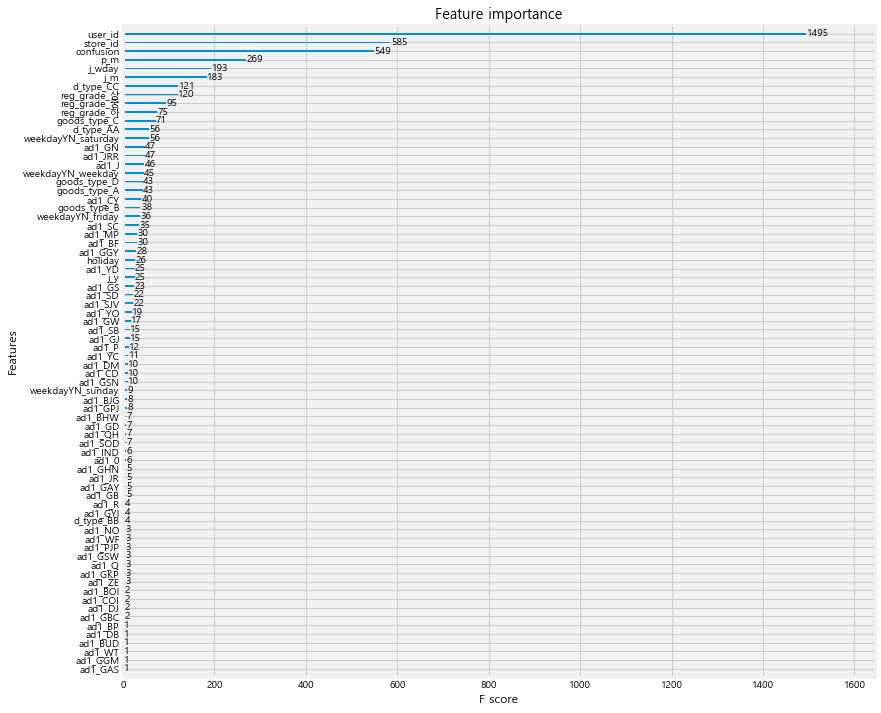

In [145]:
from xgboost import plot_importance
plt.rcParams['font.family'] = 'Malgun Gothic'
fig, ax = plt.subplots(figsize = (12, 12))
plot_importance(xgb_reg,ax=ax)

### 변수 추가로 mse의 값과 mae값은 0.01단위넘게 낮아져 모델 예측 성능의 개선이 확인되었다.
### 추가로 feature_importance를 보면 혼잡도가 3번째로 중요한 지표이며, 유저별 지역별 결제등급도 비교적 상위에
### 활용된다는 것을 알 수 있다.